## Analyzing the connection between yellow light timing, accidents, and road grades in Seattle
The Seattle open government data site (https://data.seattle.gov/) has several datasets which could be analyzed and potentially used to create a positive impact.  One particularly interesting dataset describes vehicle accidents over the last 5 years in the city of Seattle (https://data.seattle.gov/Public-Safety/Traffic-Accidents/7ayk-pspk)

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import requests
df_accidents = pd.read_csv('C:/Users/Michael/Downloads/SDOT_Collisions.csv',index_col='OBJECTID')
print df_accidents.columns
df_accidents.head()

Index([u'INCKEY', u'COLDETKEY', u'ADDRTYPE', u'COLLISIONTYPE', u'DISTANCE',
       u'EXCEPTRSNCODE', u'EXCEPTRSNDESC', u'FATALITIES', u'INATTENTIONIND',
       u'INCDATE', u'INCDTTM', u'INJURIES', u'INTKEY', u'JUNCTIONTYPE',
       u'LIGHTCOND', u'LOCATION', u'PEDCOUNT', u'PEDCYLCOUNT',
       u'PEDROWNOTGRNT', u'PERSONCOUNT', u'REPORTNO', u'ROADCOND',
       u'SDOT_COLCODE', u'SDOT_COLDESC', u'SDOTCOLNUM', u'SEGKEY',
       u'SERIOUSINJURIES', u'SEVERITYCODE', u'SEVERITYDESC', u'SPEEDING',
       u'ST_COLCODE', u'ST_COLDESC', u'STATUS', u'UNDERINFL', u'VEHCOUNT',
       u'WEATHER', u'WIDTH', u'Shape', u'SEGLANEKEY', u'CROSSWALKKEY',
       u'HITPARKEDCAR', u'SPDCASENO'],
      dtype='object')


,INCKEY,COLDETKEY,ADDRTYPE,COLLISIONTYPE,DISTANCE,EXCEPTRSNCODE,EXCEPTRSNDESC,FATALITIES,INATTENTIONIND,INCDATE,...,STATUS,UNDERINFL,VEHCOUNT,WEATHER,WIDTH,Shape,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,SPDCASENO
OBJECTID,,,,,,,,,,,,,,,,,,,,,
1,113860,113860,Block,Other,161.0,NaN,NaN,0,NaN,06/30/2010 12:00:00 AM +0000,...,Matched,N,2,Clear or Partly Cloudy,0,"(47.605141668000044, -122.33281320099996)",0,0,N,10-222469
2,113859,113859,Intersection,Pedestrian,0.0,,NaN,0,NaN,06/03/2010 12:00:00 AM +0000,...,Matched,N,1,Clear or Partly Cloudy,0,"(47.616802233000044, -122.34437532899994)",0,522632,N,10-184864
3,114135,114135,Block,Angles,166.5,NaN,NaN,0,NaN,11/06/2010 12:00:00 AM +0000,...,Matched,N,2,Overcast,0,"(47.68692783600005, -122.339782706)",0,0,N,10-388295
4,113857,113857,Intersection,Sideswipe,0.0,NaN,NaN,0,NaN,04/21/2010 12:00:00 AM +0000,...,Matched,0,2,Raining,0,"(47.534147768000025, -122.33213265299997)",0,0,N,10-129611
5,113856,113856,Intersection,Angles,0.0,NaN,NaN,0,NaN,04/19/2010 12:00:00 AM +0000,...,Matched,N,2,Clear or Partly Cloudy,0,"(47.665042553000035, -122.37076455899995)",0,0,N,10-127156


There is a lot of analysis that can be done with this data, for example we can see that an accident is much more likely to be fatal at night then it is during the day.  

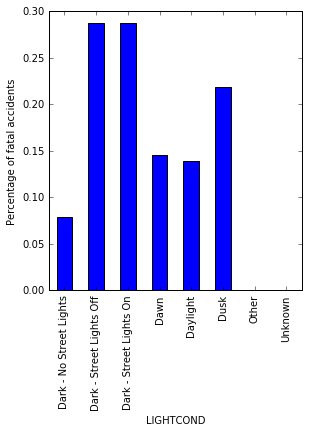

In [2]:
df_accidents['FT']=df_accidents['FATALITIES']>0
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
(100*df_accidents.groupby('LIGHTCOND').FT.sum()/df_accidents.groupby('LIGHTCOND').FT.count()).plot(kind='bar',axes=ax)
ax.set_ylabel('Percentage of fatal accidents')
plt.show()

However, what we are primarly interested in is the relationship between yellow light timing and the grade of a road approaching an intersection.   Simply put, if the road approaching an intersection has a 20% grade, it will take much longer to stop at, and should therefore a longer light time.  Using methodology per the Institute of Transportation Engineers, Ondrej calculated recommended yellow light lengths for typical posted speeds and grades found in Seattle.

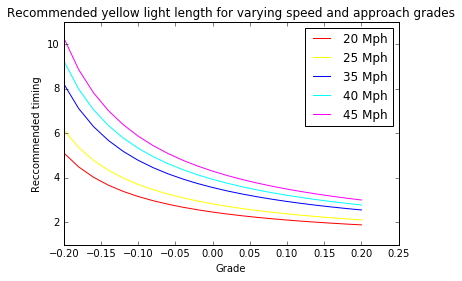

In [3]:
df_grade_timing = pd.read_csv('C:/Users/Michael/Downloads/Sheet_1_data.csv')
df_grade_timing.columns = ['Grade (%)','Speed','Yellow_Light_Time']
colors = ['red','yellow','blue','cyan','magenta','grey']
for color,speed in zip(colors,np.unique(df_grade_timing['Speed'])):
    x = df_grade_timing[df_grade_timing['Speed']==speed]['Grade (%)']
    y = df_grade_timing[df_grade_timing['Speed']==speed]['Yellow_Light_Time']
    plt.plot(x,y,c=color,label=speed)
plt.xlabel('Grade')
plt.ylabel('Reccommended timing')
plt.legend(loc='upper right')
plt.title('Recommended yellow light length for varying speed and approach grades')
plt.show()

To analyze this, we will need to download two more datasets, one of which is the street network database (https://data.seattle.gov/dataset/Street-Network-Database/afip-2mzr), which is an esri shape fileset containing information about all streets in the seattle area, and the intersection database which is a simple csv file (https://data.seattle.gov/Transportation/SDOT-Intersections/2az7-96yc).   To open the shape file, I will use geopandas, which is a library which allows you to open a .shp file into a pandas dataframe.  From these files, we will be able to obtain the grades of roads at each intersection within Seattle.

In [4]:
import geopandas as gpd
gdf_streets = gpd.read_file('C:/Users/Michael/Downloads/Street_Network_Database/WGS84/Street_Network_Database.dbf')
print gdf_streets.columns

Index([u'ACCESS_COD', u'AGENCY_COD', u'ARTERIAL_C',   u'CITYCODE',
          u'COMPKEY',   u'COMPTYPE', u'DIVIDED_CO',  u'F_INTR_ID',
       u'GIS_SEG_LE', u'LEGALLOC_C', u'L_ADRS_FRO',  u'L_ADRS_TO',
           u'L_CITY',    u'L_STATE',      u'L_ZIP', u'ORD_PRE_DI',
       u'ORD_STNAME', u'ORD_STREET', u'ORD_STRE_1', u'ORD_SUF_DI',
       u'R_ADRS_FRO',  u'R_ADRS_TO',     u'R_CITY',    u'R_STATE',
            u'R_ZIP', u'SEGMENT_TY', u'SHAPE_Leng', u'SNDSEG_UPD',
       u'SND_FEACOD',     u'SND_ID',  u'STNAME_ID', u'STRUCTURE_',
          u'ST_CODE',  u'T_INTR_ID',     u'UNITID',    u'UNITID2',
       u'VEHICLE_US',   u'geometry'],
      dtype='object')


In [5]:
df_inter = pd.read_csv('C:/Users/Michael/Downloads/SDOT_intersections.csv')
print df_inter.columns


Index([u'OBJECTID', u'INTR_ID', u'GIS_XCOORD', u'GIS_YCOORD', u'COMPKEY',
       u'COMPTYPE', u'UNITID', u'SUBAREA', u'UNITDESC', u'ARTERIALCLASSCD',
       u'SHAPE', u'SIGNAL_MAINT_DIST', u'SIGNAL_TYPE'],
      dtype='object')


The street network database includes all segments of streets.  The intersection at which the street begins is given in the column 'F_INTR_ID' and the intersection that the segment ends on is given by the column 'T_INTR_ID', where these columns refer to the 'INTR_ID' column in the intersections database.   To get the grades of the four roads associated with each intersection, we will use google's api for accessing elevation data.  Since this api is rate limited, we will first only focus on a subset of the data.  

Google's elevation api takes the generic address https://maps.googleapis.com/maps/api/elevation/outputFormat?parameters valid output formats are json and xml. A sample request would look like https://maps.googleapis.com/maps/api/elevation/json?locations=39.7391536,-104.9847034&key=YOUR_API_KEY, The location is a pair of comma seperated values, and the arguments are seperated by a single ampersand (&) sign.  Locations may also consist of multiple locations seperated by a '|' character.

In [6]:
def get_elevation(lat_lon_list,reverse_order=False):
    """Finds the elevation of several pairs of latitude and longitude.
    
    Parameters:
    --------------
    lat_lon_list: 
        A list of latitude-longitude pairs to find the elevation of.  The pairs are assumed
        to be in the form (latitude,longitude).  If pairs are in reverse order, i.e. (longi-
        tude,latitude), use reverse_order=true
    reverse_order: Boolean
        whether the pairs are given as longitude latitude pairs
        
    Returns
    ----------
    A list of elvations corresponding to each latitude longitude pair given.
    Elevations are returned in feet.  
    
    Throws 
    -----------
    Exception corresponding to the error thrown by googles elevation api, includes:
        INVALID_REQUEST indicating the API request was malformed. 
        OVER_QUERY_LIMIT indicating the requestor has exceeded quota. 
        REQUEST_DENIED indicating the API did not complete the request. 
        UNKNOWN_ERROR indicating an unknown error.
        
    """
    key = 'YOUR_API_KEY'
    lat_lon_string = ""
    if reverse_order:
        for pair in lat_lon_list:
            lat_lon_string = lat_lon_string + "{},{}".format(pair[1],pair[0]) + "|"
    else:
        for pair in lat_lon_list:
            lat_lon_string = lat_lon_string + "{},{}".format(pair[0],pair[1]) + "|"
    lat_lon_string = lat_lon_string[:len(lat_lon_string)-1]     #Don't include the | at the end.  
    url = 'https://maps.googleapis.com/maps/api/elevation/json?locations={}&key={}'\
            .format(lat_lon_string,key)
    resp = requests.get(url).json()
    if resp['status']=='OK':
        return [res['elevation'] for res in resp['results']]
    else:
        raise Exception(resp['status'])
small_df_inter = df_inter.iloc[:100,:]

We will also need the distance between two latitude and longitude pairs

In [7]:
import math
def lat_long_distance(p1,p2,reverse_order=False):
    """
    Finds the distance (in feet) between two pairs of lattitude and longitude on the earth.  This is done 
    using a flat earth approximation (valid for small distances)
    """
    radius_of_earth = 20.9*10**6
    #convert lat and lon to polar coordinates theta and phi
    theta_1,theta_2 = (90-p1[0])* np.pi/180,(90-p2[0])*np.pi/180
    phi_1,phi_2 = p1[1]*np.pi/180,p2[1]*np.pi/180
    if reverse_order:
        theta_1,phi_1 = phi_1,theta_1
        theta_2,phi_2 = phi_2,theta_2
    distance =  np.sqrt(2)*radius_of_earth*np.sqrt(1- np.cos(theta_1)*np.cos(theta_2) - 
                    np.sin(theta_1)*np.sin(theta_2)*(np.cos(phi_1)*np.cos(phi_2) + np.sin(phi_1)*np.sin(phi_2)))
    if not math.isnan(distance):
        return distance
    else:
        return 0

To convert the street segment into an grade near the intersection, we follow a 2 step process.  We take the first (or last two points, and then by drawing a strait line connecting these points, find a point Delta feet away on the strait line.  We then find the elevation difference between the two points, and devide this by the distance Delta to get the grade.  

In [8]:
def find_grade(lineString,backwards=False):
    """
    Finds the grade of a road segment, given a shapely.geometry.linestring.LineString element 
    representing it.   The grade is returned as the grade as seen from the intersection looking out.
    
    Parameters:
    ------------------
    lineString: a shapely.geometry.linestring.LineString element describing the road
        segment in question
    backwards: boolean, If you wish to calculate the grade at the end of the line segment, pass True.
        default = False
        
    Returns:
    ----------------
    a float showing the grade of the road, as viewed from the intersection in question.
        (a road which is sloping down into the intersection will have a positive grade.)
    
    Throws:
    ----------------
    Exception corresponding to the error thrown by googles elevation api, includes:
        INVALID_REQUEST indicating the API request was malformed. 
        OVER_QUERY_LIMIT indicating the requestor has exceeded quota. 
        REQUEST_DENIED indicating the API did not complete the request. 
        UNKNOWN_ERROR indicating an unknown error.        

    """
    Delta = 100 #distance to calculate slopes from
    if not backwards:
        point_1 = np.array(lineString.coords[0])
        point_2 = np.array(lineString.coords[1])
    else:
        point_1 = np.array(lineString.coords[len(lineString.coords)-1])
        point_2 = np.array(lineString.coords[len(lineString.coords)-2])
    dist = lat_long_distance(point_1,point_2,reverse_order=True)
    delta = point_2-point_1
    normalized_point_2 = point_1 + delta*Delta/dist
    elevations = get_elevation([point_1,normalized_point_2],reverse_order=True)
    elevation_diff = elevations[1]-elevations[0]
    return elevation_diff/lat_long_distance(point_1,normalized_point_2,reverse_order=True)

In [9]:
def intersection_grades(intr_id):
    """Find the grades of every road connecting to an intersection
    
    Parameters
    -------------
    intr_id: unique integer corresponding to the id of an intersection in 
        Seattles street and intersection database
    
    Returns:
    -------------
    A dataframe with the following columns:
        ORD_STNAME: the name of the street
        geometry: a shapely.geometry.linestring.LineString object describing
                the road segment.
        backwards: Whether the intersection is at the back (True) or front (false) of the line segment
        grade: The grade of the near teh intersection, as viewed from the intersection
        
    Throws:
    -------------
    Exceptions generated from calls to the google elevation API, includes:
        INVALID_REQUEST indicating the API request was malformed. 
        OVER_QUERY_LIMIT indicating the requestor has exceeded quota. 
        REQUEST_DENIED indicating the API did not complete the request. 
        UNKNOWN_ERROR indicating an unknown error.        
        
    """
    df_intersecting = gdf_streets[(gdf_streets['F_INTR_ID']==intr_id) | (gdf_streets['T_INTR_ID']==intr_id)]
    df_intersecting = df_intersecting[['ORD_STNAME',u'geometry','T_INTR_ID']]
    df_intersecting['backwards'] = df_intersecting['T_INTR_ID']==intr_id
    del df_intersecting['T_INTR_ID']
    df_intersecting['grade'] = df_intersecting.apply(lambda x:find_grade(x[1],backwards=x[2]),axis=1)
    return df_intersecting
intersection_grades(12337)

,ORD_STNAME,geometry,backwards,grade
5089,E SPRUCE ST,"LINESTRING (-122.30635024 47.60351265000003, -...",False,-0.022066
16335,20TH AVE,"LINESTRING (-122.30635024 47.60351265000003, -...",False,-0.002634
23732,E SPRUCE ST,"LINESTRING (-122.30765933 47.60351443100007, -...",True,0.005272
30874,20TH AVE,"LINESTRING (-122.306349671 47.60267346200004, ...",True,-0.002420


Now that we can compute the grades of any intersection, lets try this out on a dataset, the set of intersections is 15422 rows long, which means finding the grade of every intersection will quickly exceed googles elevation api rate limit.  We will restrict ourselves to signals which are ran by the city.  The possible values for the column SIGNAL_TYPE are [' ', 'CITY', 'FS', 'HALFPED', 'MIDXWALK', 'NONE', 'STATE'].   There are 974 rows with the name of CITY.  To make sure we don't exceed the API rate, we will additionally only consider a subset of 10 of these

In [10]:
df_inter_short = df_inter[df_inter['SIGNAL_TYPE']=='CITY'].iloc[:10,:]
df_inter_short = df_inter_short[['UNITDESC','INTR_ID']]
df_inter_short['GRADES'] = df_inter_short['INTR_ID'].map(lambda x : intersection_grades(x)[['ORD_STNAME','grade']])
df_inter_short.head()

,UNITDESC,INTR_ID,GRADES
6,8TH AVE N AND WESTLAKE N AVE N,47040,ORD_STNAME grade 4768 WESTLAK...
27,5TH AVE S AND S WELLER ST,12662,ORD_STNAME grade 30702 5TH AVE ...
31,14TH AVE S AND S TRENTON ST,18115,ORD_STNAME grade 3343 14TH AV...
69,24TH AVE NW AND NW 80TH ST,5125,ORD_STNAME grade 7736 24TH AVE N...
84,6TH AVE S AND S LANDER ST,13764,ORD_STNAME grade 7269 S LANDER S...


The last column Grades contains a dataframe with all of the streets attaching to that intersection, along with their grades.  

In [11]:
df_inter_short['GRADES'][6]

,ORD_STNAME,grade
4768,WESTLAKE AVE N,0.000700
7150,GALER ST,-0.000877
9218,WESTLAKE AVE N,-0.000036
12455,8TH AVE N,0.028206


In [12]:
df_inter_short['GRADES'][27]

,ORD_STNAME,grade
30702,5TH AVE S,0.001288
31417,5TH AVE S,-0.002082
31980,S WELLER ST,0.002486
